# `Learning-based Cost Evaluation and Lyapunov Functions for Hybrid Systems`

Consider the following hybrid oscillator given by

$$
\begin{equation*}
    \mathcal{H}: \left\{ \begin{array}{ll}
        \dot{x} = F(x) := \begin{pmatrix}
            x_2 \\ -x_1 - \lambda_C x_2
        \end{pmatrix}, & \quad C = \{x\in\mathbb{R}^2 : x_1 \geq 0\} \\
        x^+ = G(x) := \begin{pmatrix}
            0 \\ -\lambda_D x_2
        \end{pmatrix}, & \quad D = \{x\in\mathbb{R}^2 : x_1 = 0, x_2 \leq 0\}
    \end{array} \right.
\end{equation*}
$$

where $\lambda_C > 0$ and $\lambda_D \in (0, 1)$.

In [1]:
""" Please change the following boolean variable depending on which results you would like to reproduce """
training_lyapunov = True  # change to False for data-driven cost upper bound

## `Data of the Hybrid System`

In [2]:
import jax
import jax.numpy as jnp
from collections import namedtuple
import numpy as np


class HyOscillator:
    def __init__(self, params) -> None:
        self.params = params
        self._gen_dynamics()

    def _gen_dynamics(self):
        """
        Create jump and flow maps
        """

        def _f(x):
            # Flow map
            x_dot = jnp.array([x[1], -x[0] - self.params.lam * x[1]])
            return x_dot

        def _g(x):
            # Jump map
            x_plus = jnp.array([0, -self.params.lam * x[1]])
            return x_plus

        self.f = _f
        self.g = _g


bb = HyOscillator(
    namedtuple(
        "BouncingBallParams",
        ["gamma", "lam"],
        defaults=[9.81, 0.6],
    )()
)

## `Cost Evaluation - Learning a Lyapunov-like function from data`

### `DNN-related`


In [3]:
import os
from utils import AverageMeter


def train(x_flows, x_jumps, net, args):
    """Helper functions to calculate constraints violation"""
    flows_penalty = (
        lambda x, params: jax.vmap(net.flows_constraint_indiv, in_axes=(0, None))(
            x, params
        )
        + args.gam_C
    )
    jumps_penalty = (
        lambda x, params: jax.vmap(net.jumps_constraint_indiv, in_axes=(0, None))(
            x, params
        )
        + args.gam_D
    )

    params = net.init_params(verbose=True)
    opt_state = net.opt_init(params)

    loss_tracker = AverageMeter("loss", fmt=".3f")

    dataset = {"x_flows": x_flows, "x_jumps": x_jumps}

    # l2 norm of constraints
    eta = jnp.array([0.0])
    # penalty tolerance
    epsilon = jnp.array([1e-8])

    # training loop
    for epoch_idx in range(1, args.n_epochs + 1):
        params = net.get_params(opt_state)

        # compute loss and update tracker
        loss = net.loss(params, dataset)
        consts = net.constraints(params, dataset)

        # update loss tracker
        loss_tracker.update(loss, n=1)

        # do one step of optimization
        opt_state = net.step(epoch_idx, opt_state, dataset)

        if epoch_idx % args.report_int == 0:
            print(f"[Epoch: {epoch_idx}/{args.n_epochs}]", end=" ")
            print(f"[Loss: {loss_tracker.val:.3f}]")
            print(f'\t[Flows pct: {consts["flows"]:.3f}]', end=" ")
            print(f'[Jumps pct: {consts["jumps"]:.3f}]', end=" ")

        # update Lagrange multipliers estimates
        pen_C, pen_D = -flows_penalty(
            x_flows, net.get_params(opt_state)
        ), -jumps_penalty(x_jumps, net.get_params(opt_state))
        penalty = jnp.sum(pen_C) + jnp.sum(pen_D)
        if (
            jnp.linalg.norm(penalty) >= 0.25 * eta
            and jnp.linalg.norm(penalty) > epsilon
        ):
            net.lam_C = (net.lam_C - pen_C / net.mu) * jnp.sign(
                jax.nn.relu(pen_C - net.mu * net.lam_C)
            )
            net.lam_D = (net.lam_D - pen_D / net.mu) * jnp.sign(
                jax.nn.relu(pen_D - net.mu * net.lam_D)
            )
        else:
            net.mu *= 0.1

        eta = jnp.linalg.norm(penalty)

    # define learned Lyapunov function as python function
    final_params = net.get_params(opt_state)
    learned_V = lambda x: net.forward_indiv(x, final_params, net.act_fun)

    return learned_V, final_params

### `Getting the data`

In [4]:
def get_epsilon_net_flow_set(epsilon, a, b, mu=None):
    """Creates an epsilon-net by random sampling

    Args:
        epsilon: discretization size.
        a: bound on the x-axis.
        b: bound on the y-axis.
        mu: size of ball around origin. Defaults to None.
    Returns:
        Numpy array with the epsilon net.
    """
    net_points = []
    x_range = np.arange(0, a + epsilon, epsilon)
    y_range = np.arange(-b, b + epsilon, epsilon)

    for x in x_range:
        for y in y_range:
            if mu is not None:
                if (x / a) ** 2 + (y / b) ** 2 <= 1 and (x**2 + y**2) > mu**2:
                    net_points.append((x, y))
            else:
                if (x / a) ** 2 + (y / b) ** 2 <= 1:
                    net_points.append((x, y))

    return np.array(net_points)


def get_epsilon_net_jump_set(epsilon, v_min, v_max, mu=None):
    """Creates an epsilon-net by random sampling

    Args:
        epsilon: discretization size.
        v_min: minimum bound on the jump set to sample from.
        v_max: maximum bound on the jump set to sample from.
        mu: size of ball around origin. Defaults to None.
    Returns:
        Numpy array with the epsilon net.
    """

    net_points = []
    # Start from the minimum x_2 value
    x2 = v_min

    while x2 < v_max:
        if mu is not None:
            if np.abs(x2) > mu:
                net_points.append([0, x2])
        else:
            net_points.append([0, x2])
        x2 += epsilon

    return np.array(net_points)


# get the data
v0, g = 1.5, 9.81
u = v = 0.0  # center
b = v0  # radius on the y-axis
eps = 0.01  # Set your desired epsilon value
a = 1

mu = 1.1 * eps if training_lyapunov == True else None

F_C = get_epsilon_net_flow_set(eps, a, b, mu=mu)
F_D = get_epsilon_net_jump_set(eps, -b, 0, mu=mu)

In [5]:
def get_epsilon_net_flow_set(epsilon, a, b, mu=None):
    net_points = []
    x_range = np.arange(0, a + epsilon, epsilon)
    y_range = np.arange(-b, b + epsilon, epsilon)

    for x in x_range:
        for y in y_range:
            if mu is not None:
                if (x / a) ** 2 + (y / b) ** 2 <= 1 and (
                    x**2 + y**2
                ) > mu**2:
                    net_points.append((x, y))
            else:
                if (x / a) ** 2 + (y / b) ** 2 <= 1:
                    net_points.append((x, y))

    return np.array(net_points)


def get_epsilon_net_jump_set(epsilon, v_min, v_max, mu=None):
    net_points = []
    # Start from the minimum x2 value
    x2 = v_min

    while x2 < v_max:
        if mu is not None:
            if np.abs(x2) > mu:
                net_points.append([0, x2])
        else:
            net_points.append([0, x2])
        x2 += epsilon

    return np.array(net_points)


# get the data
v0, g = 1.5, 9.81
u = v = 0.0  # center
b = v0  # radius on the y-axis
eps = 0.01  # Set your desired epsilon value
a = 1

F_C = get_epsilon_net_flow_set(eps, a, b, mu=1.1 * eps)
F_D = get_epsilon_net_jump_set(eps, -b, 0, mu=1.1 * eps)

### `Train the neural net`

In [6]:
from utils import NeuralNet

# directory to save all output plots and saved network parameters
results_dir = "./saved_models"
report_int = 10

# architecture and training hyperparameters
net_dims = (2, 16, 32)
n_epochs = 230 if training_lyapunov else 500

# Lagrange multipliers/coefficients
lam_C = jnp.ones(F_C.shape[0])
lam_D = jnp.ones(F_D.shape[0])
mu = 1.0
lam_grad = 0.01
lam_param = 0.5

# Loss margin hyperparameters
gam_C = 0.037 if training_lyapunov == True else 0.058
gam_D = 0.049 if training_lyapunov == True else 0.045

# activation function
act_fun = jnp.tanh

args = namedtuple(
    "NeuralNetParams",
    [
        "results_dir",
        "report_int",
        "net_dims",
        "n_epochs",
        "lam_C",
        "lam_D",
        "mu",
        "lam_grad",
        "lam_param",
        "gam_C",
        "gam_D",
        "reload",
    ],
    defaults=[
        results_dir,
        report_int,
        net_dims,
        n_epochs,
        lam_C,
        lam_D,
        mu,
        lam_grad,
        lam_param,
        gam_C,
        gam_D,
        False,
    ],
)()

net = NeuralNet(
    net_dims=args.net_dims,
    args=args,
    dyn=bb,
    act_fun=act_fun,
    ell_C=None
    if training_lyapunov == True
    else lambda x: 0.5 * jnp.linalg.norm(x) ** 2,
    ell_D=None
    if training_lyapunov == True
    else lambda x: 0.15 * jnp.linalg.norm(x) ** 2,
    opt_name="Adam",
    opt_kwargs={"step_size": 0.005},
)

learned_V, trained_params = train(F_C, F_D, net, args)

Training for practical pAS!
Param shapes are: [((2, 2), (2, 14)), ((9, 16), (16, 16))]
[Epoch: 10/230] [Loss: 989.500]
	[Flows pct: 59.871] [Jumps pct: 100.000] [Epoch: 20/230] [Loss: -401.323]
	[Flows pct: 58.740] [Jumps pct: 100.000] [Epoch: 30/230] [Loss: -1355.519]
	[Flows pct: 63.753] [Jumps pct: 100.000] [Epoch: 40/230] [Loss: -1942.269]
	[Flows pct: 66.809] [Jumps pct: 100.000] [Epoch: 50/230] [Loss: -2510.431]
	[Flows pct: 69.104] [Jumps pct: 100.000] [Epoch: 60/230] [Loss: -3036.849]
	[Flows pct: 71.755] [Jumps pct: 100.000] [Epoch: 70/230] [Loss: -3533.274]
	[Flows pct: 73.894] [Jumps pct: 100.000] [Epoch: 80/230] [Loss: -3988.893]
	[Flows pct: 75.304] [Jumps pct: 100.000] [Epoch: 90/230] [Loss: -4406.619]
	[Flows pct: 77.663] [Jumps pct: 100.000] [Epoch: 100/230] [Loss: -4832.872]
	[Flows pct: 79.579] [Jumps pct: 100.000] [Epoch: 110/230] [Loss: -5278.459]
	[Flows pct: 81.908] [Jumps pct: 100.000] [Epoch: 120/230] [Loss: -5705.178]
	[Flows pct: 84.377] [Jumps pct: 100.000] [

### `Check the Lipschitz conditions over the epsilon-net`

In [7]:
import jax

""" Calculate Lipschitz constant of the LHS of constraints for flows """
compute_Lip_qC = lambda x, params: jnp.linalg.norm(
    jax.grad(net.flows_constraint_indiv, argnums=0)(x, params)
)
certify_Lip = lambda eps, L, gamma: eps - gamma / L
L_qC = jax.vmap(compute_Lip_qC, in_axes=(0, None))(F_C, trained_params)
flag_L_qC = jax.vmap(certify_Lip, in_axes=(None, 0, None))(eps, L_qC, gam_C)

cnt_pct = sum(flag_L_qC < 0) / F_C.shape[0] * 100

print("Percentage of eps - gamma / LqC < 0: {0:.0f}%".format(round(cnt_pct, 1)))
# Repeat the count for q_C + L_qC * eps < 0
qC = jax.vmap(net.flows_constraint_indiv, in_axes=(0, None))(F_C, trained_params)
cnt_pct = sum(qC + L_qC * eps < 0) / F_C.shape[0] * 100

# print("Percentage of qC + eps * LqC < 0: {0:.0f}%".format(round(cnt_pct, 1)))

""" Calculate Lipschitz constant of the LHS of constraints for jumps """
compute_Lip_qD = lambda x, params: jnp.linalg.norm(
    jax.grad(net.jumps_constraint_indiv, argnums=0)(x, params)
)
L_qD = jax.vmap(compute_Lip_qD, in_axes=(0, None))(F_D, trained_params)
flag_L_qD = jax.vmap(certify_Lip, in_axes=(None, 0, None))(eps, L_qD, gam_D)

cnt_pct = sum(flag_L_qD < 0) / F_D.shape[0] * 100

print("Percentage of eps - gamma / LqD < 0: {0:.0f}%".format(round(cnt_pct, 1)))
# Repeat the count for q_D + L_qD * eps < 0
qD = jax.vmap(net.jumps_constraint_indiv, in_axes=(0, None))(F_D, trained_params)
cnt_pct = sum(qD + L_qD * eps < 0) / F_D.shape[0] * 100

# print("Percentage of qD + eps * LqD < 0: {0:.0f}%".format(round(cnt_pct, 1)))

# Suggestions for picking gamma_C
print("")
print("*** Guidelines for choosing gam_C ( currently", gam_C, ") ***")
print("max(eps)*max(L_qC) =", eps * max(L_qC))
print("mean(eps)*mean(L_qC) =", eps * np.mean(L_qC))
print("median(eps)*median(L_qC) =", eps * np.median(L_qC))

# Suggestions for picking gamma_D
print("")
print("*** Guidelines for choosing gam_D ( currently", gam_D, ") ***")
print("max(eps)*max(L_qD) =", eps * max(L_qD))
print("mean(eps)*mean(L_qD) =", eps * np.mean(L_qD))
print("median(eps)*median(L_qD) =", eps * np.median(L_qD))

Percentage of eps - gamma / LqC < 0: 99%
Percentage of eps - gamma / LqD < 0: 100%

*** Guidelines for choosing gam_C ( currently 0.037 ) ***
max(eps)*max(L_qC) = 0.04213182
mean(eps)*mean(L_qC) = 0.0110939145
median(eps)*median(L_qC) = 0.01007042169570923

*** Guidelines for choosing gam_D ( currently 0.049 ) ***
max(eps)*max(L_qD) = 0.037470765
mean(eps)*mean(L_qD) = 0.013736521
median(eps)*median(L_qD) = 0.011687635183334351


### `Plot the surfaces`

The next cell loads a hybrid trajectory of the oscillator with the initial conditions $x(0, 0) = [0.075, 1.1]^\top$. In the folder `HyOscillator_Dynamics` you can find the Matlab code to get a hybrid arc given a initial condition.

In [8]:
import scipy.io

mat = scipy.io.loadmat("HyArc.mat")

jts = mat["jts"]
ts = mat["ts"]
states = mat["x"]

# find the indices of jumps
idxs = [0]
for jt in jts:
    idxs.append(np.argmin(np.abs(jt - ts)))

# get the intervals of flow to plot
flows = []
for i in range(len(idxs) - 1):
    start_index = idxs[i]
    end_index = idxs[i + 1]
    flows.append(states[start_index:end_index])

/Users/cmontene/opt/anaconda3/envs/safeRL/lib/python3.7/site-packages/scipy/io/matlab/mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


The next cell plots the learned Lyapunov function (`training_lyapunov=True`) or the learned value function (`training_lyapunov=False`).

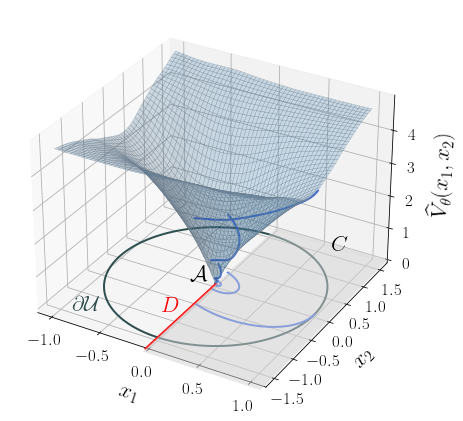

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from utils import latexify

# Helper functions
params = net.init_params()

latexify(fig_height=6, fig_width=8)
fig = plt.figure()
""" Lyapunov function """
ax = fig.add_subplot(111, projection="3d")

# create mesh
x, y = np.linspace(-a, a, 500), np.linspace(-b, b, 500)
X, Y = np.meshgrid(x, y)

Vvals = jax.vmap(
    lambda s1: jax.vmap(
        lambda s2: learned_V(jnp.array([s2, s1])), 
    )(x)
)(y)


ax.plot_surface(
    X,
    Y,
    Vvals,
    edgecolor="lightslategray",
    lw=0.2,
    # rstride=6,
    # cstride=6,
    alpha=0.2,
)

# Plot the set calU
t = np.linspace(0, 2 * np.pi, 100)
xc, yc = a * np.cos(t), b * np.sin(t)
ax.plot(xc[:], yc[:], "darkslategray", linewidth=2, label=r"$\partial\mathcal{U}$")

# Plot flow set
vertices = [
    [(0, 1.15*b, 0), (1.15*a, 1.15*b, 0), (1.15*a, -1.25*b, 0), (0, -1.25*b, 0)]
]
ax.add_collection3d(Poly3DCollection(vertices, alpha=0.5, facecolors='lightgray'))
# just for labeling purposes
plt.plot([], [], 's', label=r'$C$', color='lightgray')

# Label axes
ax.set_xlabel(r"$x_1$", labelpad=10, fontsize=22)
ax.set_ylabel(r"$x_2$", labelpad=10, fontsize=22)
ax.set_zlabel(r"$\widehat{V}_\theta(x_1, x_2)$", labelpad=10, fontsize=22)

ax.set_xlim(-1.1*a, a*1.1)
ax.set_ylim(-b*1.1, b*1.1)

""" Only plot the hybrid solution if we are learning for practial pre-asymptotic stability """
if training_lyapunov:
    # Plot state evolution
    for fl in flows:
        ax.plot(fl[1:, 0], fl[1:, 1], linewidth=2.0, color="royalblue")

    # Plot Lyapunov function evaluated at flows/jumps
    for fl in flows:
        x1, x2 = fl[1:, 0], fl[1:, 1]
        V = jax.vmap(
            lambda s1, s2: learned_V(jnp.array([s1, s2])),
        )(x1, x2)
        ax.plot3D(
            x1,
            x2,
            V,
            color="royalblue",
            linewidth=2.0
        )

# Plot the jump set
ax.plot(np.zeros_like(xc), np.linspace(-1.2*b, 0, len(xc)), 'red', linewidth=2, label=r"$D$")

ax.annotate(r"$D$", xy=(0.38, 0.25), color='red', xycoords="axes fraction", fontsize=22)
ax.annotate(r"$\partial\mathcal{U}$", xy=(0.16, 0.25), color='darkslategray', xycoords="axes fraction", fontsize=22)
ax.annotate(r"$C$", xy=(0.8, 0.4), xycoords="axes fraction", fontsize=22)
if training_lyapunov:
    ax.annotate(r"$\mathcal{A}$", xy=(0.45, 0.32), xycoords="axes fraction", fontsize=22)

ax.tick_params(axis='both', which='major', labelsize=17)

fig.tight_layout()
# plt.savefig("figs/learned_lyap_ce.pdf", bbox_inches="tight")
plt.show()

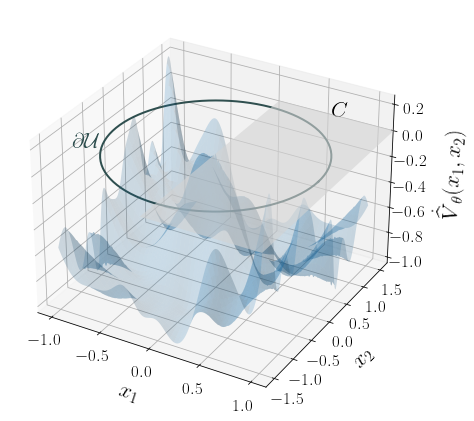

In [10]:
""" Helper functions """
V_dot_indiv = lambda x: jnp.dot(net.dyn.f(x), net.model_grad_indiv(x, trained_params))

# create mesh
x, y = np.linspace(-a, a, 500), np.linspace(-b, b, 500)
X, Y = np.meshgrid(x, y)

V_dot_vals = jax.vmap(
    lambda s1: jax.vmap(
        lambda s2: V_dot_indiv(jnp.array([s2, s1])),
    )(x)
)(y)

# Show Figure 3 only if training_lyapunov=True
if training_lyapunov:
    latexify(fig_height=6, fig_width=8)
    fig = plt.figure()

    """ Time derivative of Lyapunov function """
    ax = fig.add_subplot(111, projection="3d")

    ax.plot_surface(
        X,
        Y,
        V_dot_vals,
        edgecolor="lightslategray",
        lw=0.0,
        # rstride=6,
        # cstride=6,
        alpha=0.2,
    )

    # Plot the set calU
    t = np.linspace(0, 2 * np.pi, 100)
    xc, yc = a * np.cos(t), b * np.sin(t)
    ax.plot(xc[:], yc[:], "darkslategray", linewidth=2, label=r"$\partial\mathcal{U}$")

    # Plot the flow set

    vertices = [
        [
            (0, 1.15 * b, 0),
            (1.15 * a, 1.15 * b, 0),
            (1.15 * a, -1.25 * b, 0),
            (0, -1.25 * b, 0),
        ]
    ]
    ax.add_collection3d(Poly3DCollection(vertices, alpha=0.6, facecolors="lightgray"))
    # just for labeling purposes
    plt.plot([], [], "s", label=r"$C$", color="lightgray")


    ax.annotate(
        r"$\partial\mathcal{U}$",
        xy=(0.16, 0.65),
        color="darkslategray",
        xycoords="axes fraction",
        fontsize=22,
    )
    ax.annotate(r"$C$", xy=(0.8, 0.73), xycoords="axes fraction", fontsize=22)
    # ax.annotate(r"$\mathcal{A}$", xy=(0.45, 0.32), xycoords="axes fraction", fontsize=22)

    ax.tick_params(axis="both", which="major", labelsize=17)

    ax.set_xlabel(r"$x_1$", labelpad=10, fontsize=22)
    ax.set_ylabel(r"$x_2$", labelpad=10, fontsize=22)
    ax.set_zlabel(r"$\dot{\widehat{V}}_\theta(x_1, x_2)$", labelpad=15, fontsize=22)

    fig.tight_layout()
    # plt.savefig("figs/dotV_lyap_surface.pdf", bbox_inches="tight")

    plt.show()

Run the next code cells to get Figure 4.

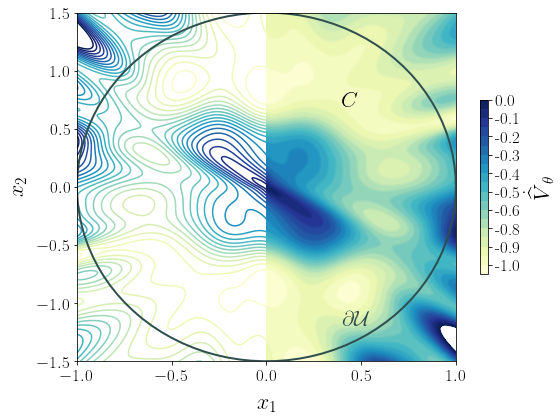

In [11]:
import matplotlib.ticker as tkr

if training_lyapunov:
    latexify(fig_height=6, fig_width=8)
    fig = plt.figure()

    """ Time derivative of Lyapunov function """
    ax2 = fig.add_subplot(111)

    ax2.contour(
        X,
        Y,
        V_dot_vals,
        levels=np.linspace(V_dot_vals.min(), 0, 20),
        cmap="YlGnBu",
    )

    c1 = ax2.contourf(
        X,
        Y,
        np.where(X > 0, V_dot_vals, np.nan),
        levels=np.linspace(V_dot_vals.min(), 0, 20),
        cmap="YlGnBu",
    )
    cbar = plt.colorbar(c1, ax=ax2, shrink=0.5, format=tkr.FormatStrFormatter('%.1f'))
    cbar.set_label(r"$\dot{\widehat{V}}_\theta$", fontsize=22)
    cbar.ax.tick_params(labelsize=17)

    # Plot the set calU
    t = np.linspace(0, 2 * np.pi, 100)
    xc, yc = a * np.cos(t), b * np.sin(t)
    ax2.plot(xc[:], yc[:], "darkslategray", linewidth=2, label=r"$\partial\mathcal{U}$")

    ax2.tick_params(axis="both", which="major", labelsize=17)
    ax2.set_xlabel(r"$x_1$", labelpad=10, fontsize=22)
    ax2.set_ylabel(r"$x_2$", labelpad=10, fontsize=22)

    ax2.annotate(
        r"$\partial\mathcal{U}$",
        xy=(0.7, 0.10),
        color="darkslategray",
        xycoords="axes fraction",
        fontsize=22,
    )
    ax2.annotate(r"$C$", xy=(0.7, 0.73), xycoords="axes fraction", fontsize=22)

    fig.tight_layout()

    plt.show()